In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

pd.show_versions()
print('\ntensorflow: ',tf.__version__)


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.6.final.0
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.23.4
pytest: 3.8.2
pip: 19.0.3
setuptools: 41.0.1
Cython: 0.28.5
numpy: 1.16.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 7.0.1
sphinx: 1.8.1
patsy: 0.5.0
dateutil: 2.7.3
pytz: 2018.5
blosc: None
bottleneck: 1.2.1
tables: 3.4.4
numexpr: 2.6.8
feather: None
matplotlib: 2.2.2
openpyxl: 2.5.8
xlrd: 1.1.0
xlwt: 1.3.0
xlsxwriter: 1.1.1
lxml: 4.2.5
bs4: 4.6.3
html5lib: 0.9999999
sqlalchemy: 1.2.11
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: 0.7.0

tensorflow:  1.13.0-rc2


In [ ]:
def get_and_process_wine_data():
    df = pd.read_csv('winemag-data_first150k.csv') 
    # unnecessary id
    del df['Unnamed: 0']
    del df['description']
    # too many categorical variables
    del df['designation']
    del df['province']
    del df['region_1']
    del df['winery']
    df = pd.get_dummies(df,['country','region_2','variety'])
    df = df.dropna()
    
    return df

In [60]:
def create_random_data(size_n = 500, n_labels = 2):
    df = pd.DataFrame(np.random.randint \
                      (0,100,size=(size_n, 4)), columns=list('ABCD'))
    df['E'] = np.random.randint(0,n_labels,size=(size_n, 1))
    return df

In [14]:
def create_train_test_splits(df, column_to_predict):
    train_dataset = df.sample(frac=0.8,random_state=0)
    test_dataset = df.drop(train_dataset.index)
    train_labels = train_dataset.pop(column_to_predict)
    test_labels = test_dataset.pop(column_to_predict)

    return train_dataset, test_dataset, train_labels, test_labels

In [92]:
def build_train_model(n_samples, epochs, n_labels, n_threads, \
                      iterations, column_to_predict, \
                      suppress_prints = True):

    df = create_random_data(n_samples, n_labels)
    train_dataset, test_dataset, train_labels, test_labels = \
                        create_train_test_splits(df,column_to_predict)
    train_dataset = train_dataset.astype(float)
    
    x = tf.placeholder(dtype = tf.float32, shape = [None, train_dataset.shape[1]])
    y = tf.placeholder(dtype = tf.int32, shape = [None])
    
    # set up loss functions, optimizer, and accuracy metrics
    logits = tf.contrib.layers.fully_connected(train_dataset, n_labels, tf.nn.relu)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits \
                              (labels = y, logits = logits))
    train_op = tf.train.AdamOptimizer(learning_rate=0.001) \
                            .minimize(loss)
    correct_pred = tf.argmax(logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    train_time = {'time':[],'epochs':[],'thread count':[],
                  'label count':[], 'sample count':[]}
    
    for i in range(iterations):
        
        # sets up session
        tf.set_random_seed(1)
        sess = tf.Session(config=tf.ConfigProto(
            intra_op_parallelism_threads=n_threads))
        sess.run(tf.global_variables_initializer())
    
    
        # train and time model
        start = time.time()
        for i in range(epochs):
            if not suppress_prints: print('Epoch: ', i)
            _, accuracy_val = sess.run([train_op, accuracy], \
                    feed_dict={x: train_dataset, y: train_labels})
            if not suppress_prints: print('Accuracy: ', accuracy_val)
        end = time.time()
        total_time = end - start
        
        # record training times
        train_time['time'].append(total_time)
        train_time['epochs'].append(epochs)
        train_time['thread count'].append(n_threads)
        train_time['label count'].append(n_labels)
        train_time['sample count'].append(n_samples)
        
    return train_time

In [93]:
# BUILD AND TRAIN MODEL
n_samples = 10000
epochs = 200
n_labels = 2
n_threads = 1
iterations = 20
column_to_predict = 'E'
time_d = build_train_model(n_samples, epochs, n_labels, n_threads, \
                          iterations, column_to_predict)

# DISPLAY RESULTS
cols = ['time', 'epochs', 'thread count', 'label count', 'sample count']
time_df = pd.DataFrame(data = time_d, columns=cols)
time_df.head(3)

,time,epochs,thread count,label count,sample count
0,2.589517,200,1,2,10000
1,3.051240,200,1,2,10000
2,2.204739,200,1,2,10000


In [94]:
# BUILD AND TRAIN MODEL
n_samples = 1000
epochs = 50
n_labels = 2
iterations = 20
column_to_predict = 'E'
thread_max = 4

thread_d = {}

for n_threads in range(1, thread_max+1):
    time_d = build_train_model(n_samples, epochs, n_labels, n_threads, \
                              iterations, column_to_predict)
    cols = ['time', 'epochs', 'thread count', 'label count', 'sample count']
    time_df = pd.DataFrame(data = time_d, columns=cols)
    thread_d[str(n_threads)+' thread(s)'] = time_df

In [99]:
thread_df = pd.DataFrame()

for i in range(1, thread_max+1):
    thread_df = thread_df.append(thread_d[str(i)+' thread(s)']['time'], ignore_index=True)

thread_df = thread_df.transpose()
thread_df.columns = ['1', '2', '3', '4']
thread_df

,1,2,3,4
0,0.888499,0.761565,0.656620,0.852512
1,0.893493,0.802543,0.454744,0.415762
2,0.683015,0.909481,0.419763,0.612653
3,0.875267,0.810536,0.371791,0.884500
4,0.703598,0.770560,0.332812,0.778039
5,0.700866,0.821530,0.323817,0.749602
6,0.688606,0.785556,1.018419,0.736580
7,0.681770,0.874491,0.775558,0.733704
8,0.694608,1.213306,0.575679,0.744573
9,0.704597,0.417761,0.514705,0.680609


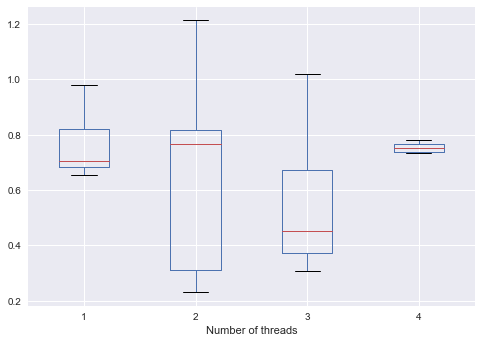

In [107]:
thread_df.boxplot()
plt.xlabel('Number of threads')
plt.savefig('boxplots_of_'+str(epochs)+ \
            '_epochs_'+str(n_samples)+'_samples.png')

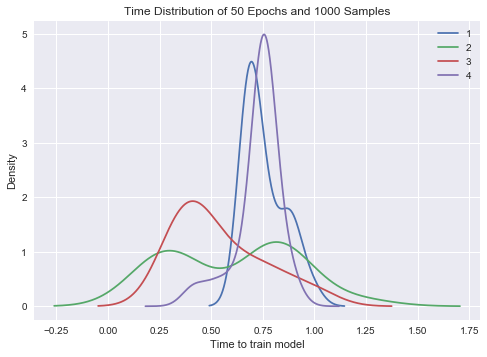

In [104]:
thread_df.plot.kde()
plt.xlabel('Time to train model')
plt.title('Time Distribution of '+str(epochs)+ \
            ' Epochs and '+str(n_samples)+' Samples')
plt.savefig('time_distribution_'+str(epochs)+ \
            '_epochs_'+str(n_samples)+'_samples.png')

In [106]:
thread_df.to_csv('time_df_'+str(epochs)+ \
            '_epochs_'+str(n_samples)+'_samples.csv')

In [ ]:
def train_model_per_thread(epochs, n_samples):
    n_labels = 2
    iterations = 20
    column_to_predict = 'E'
    thread_max = 4
    
    thread_d = {}
    
    for n_threads in range(1, thread_max+1):
        time_d = build_train_model(n_samples, epochs, n_labels, n_threads, \
                                  iterations, column_to_predict)
        cols = ['time', 'epochs', 'thread count', 'label count', 'sample count']
        time_df = pd.DataFrame(data = time_d, columns=cols)
        thread_d[str(n_threads)+' thread(s)'] = time_df
        
    thread_df = pd.DataFrame()
    
    for i in range(1, thread_max+1):
        thread_df = thread_df.append(thread_d[str(i)+' thread(s)']['time'], ignore_index=True)
    
    thread_df = thread_df.transpose()
    thread_df.columns = ['1', '2', '3', '4']
    
    thread_df.boxplot()
    plt.xlabel('Number of threads')
    plt.ylabel('Time to train model')
    plt.savefig('boxplots_of_'+str(epochs)+ \
            '_epochs_'+str(n_samples)+'_samples.png')
    
    thread_df.plot.kde()
    plt.xlabel('Time to train model')
    plt.title('Time Distribution of '+str(epochs)+ \
                ' Epochs and '+str(n_samples)+' Samples')
    plt.savefig('time_distribution_'+str(epochs)+ \
                '_epochs_'+str(n_samples)+'_samples.png')
    
    thread_df.to_csv('time_df_'+str(epochs)+ \
            '_epochs_'+str(n_samples)+'_samples.csv')

In [113]:
epochs_list = [10, 20]
n_samples_list = [100, 1000]

for epochs in epochs_list:
    for n_samples in n_samples_list:
        #train_model_per_thread(epochs, n_samples)
        print('', end='')

In [119]:
time_d = {}
time_d['100'] = pd.read_csv('time_df_50_epochs_100_samples.csv')
time_d['1000'] = pd.read_csv('time_df_50_epochs_1000_samples.csv')
time_d['10000'] = pd.read_csv('time_df_50_epochs_10000_samples.csv')
time_d['100000'] = pd.read_csv('time_df_50_epochs_100000_samples.csv')
time_d['1000000'] = pd.read_csv('time_df_50_epochs_1000000_samples.csv')
for d in time_d:
    del time_d[d]['Unnamed: 0']
time_d['100'].head(5)

,1,2,3,4
0,0.058573,0.048409,0.052112,0.051876
1,0.052421,0.046760,0.054724,0.047063
2,0.044544,0.047071,0.048809,0.047420
3,0.044417,0.047780,0.047673,0.050629
4,0.044598,0.049259,0.048456,0.049608


In [120]:
sp_d = {}
ts = time_d['100']['1'].mean()
for tp_index in time_d['100']:
    sp_d[tp_index] = ts/time_d['100'][tp_index].mean()
sp_d

{'1': 1.0,
 '2': 0.9999392812338875,
 '3': 0.9525004098912079,
 '4': 0.9532963906298442}

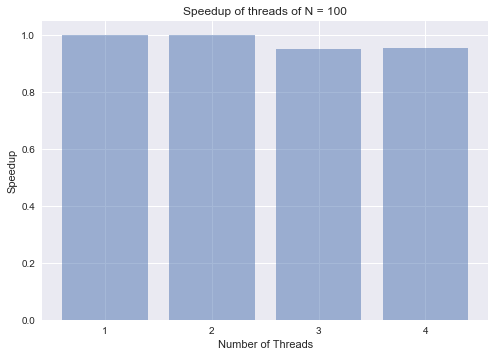

In [123]:
plt.bar(range(len(sp_d)), list(sp_d.values()), align='center', alpha = 0.5)
plt.xticks(range(len(sp_d)), list(sp_d.keys()))
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.title('Speedup of threads of N = 100')
plt.show()

{'1': 1.0, '2': 0.9999392812338875, '3': 0.9525004098912079, '4': 0.9532963906298442}


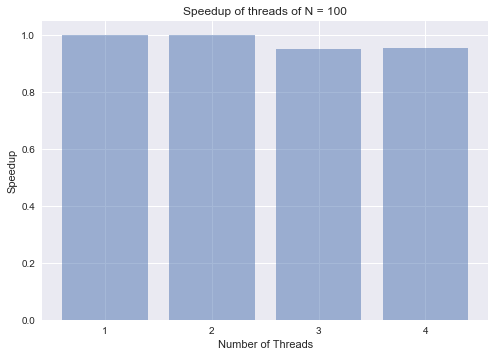

{'1': 1.0, '2': 0.9675653759871321, '3': 0.9620943876180409, '4': 0.9755002312999882}


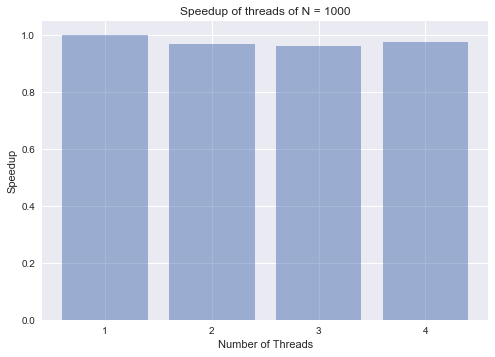

{'1': 1.0, '2': 0.9992889161032775, '3': 0.9978697778431769, '4': 1.0156787581993667}


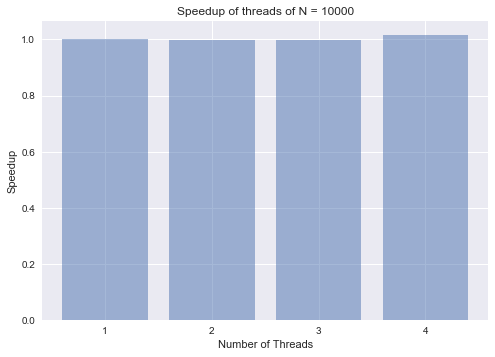

{'1': 1.0, '2': 0.9574559346666204, '3': 0.9710893434914533, '4': 0.9295949698940099}


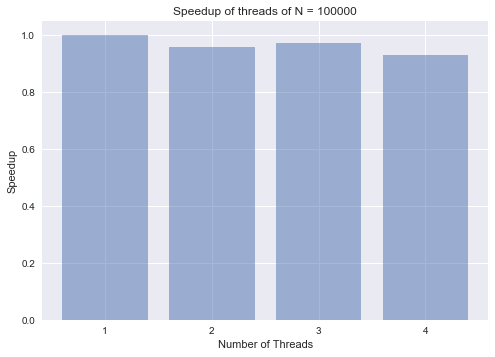

{'1': 1.0, '2': 1.0120441929340638, '3': 1.011768818281633, '4': 1.033819209241825}


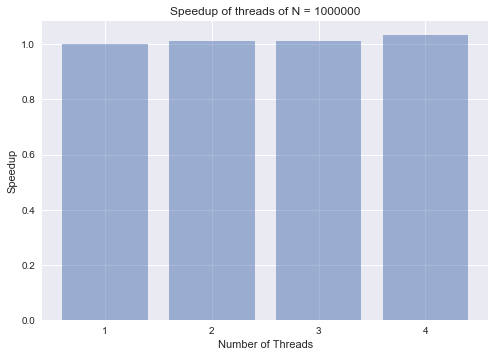

In [127]:
n_list = ['100','1000','10000','100000','1000000']
for n in n_list:
    sp_d = {}
    ts = time_d[n]['1'].mean()
    for tp_index in time_d[n]:
        sp_d[tp_index] = ts/time_d[n][tp_index].mean()
        
    print(sp_d)
        
    plt.bar(range(len(sp_d)), list(sp_d.values()), align='center', alpha = 0.5)
    plt.xticks(range(len(sp_d)), list(sp_d.keys()))
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup')
    plt.title('Speedup of threads of N = '+n)
    plt.show()

{'1': 1.0, '2': 0.968794337099754, '3': 0.9327353488897734, '4': 0.9358715211871719}


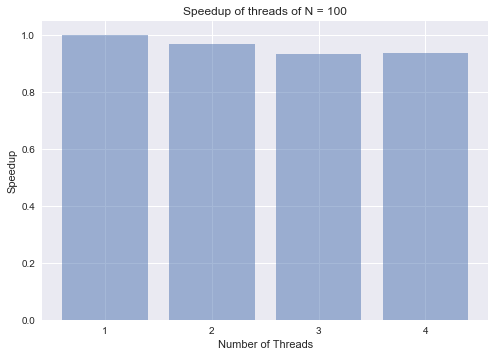

{'1': 1.0, '2': 0.9773658932383976, '3': 0.9653429941644455, '4': 0.9673669951865651}


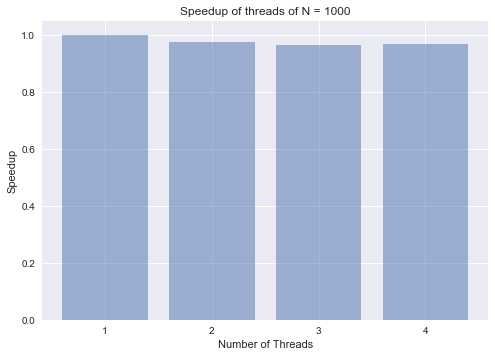

{'1': 1.0, '2': 1.0043742577983894, '3': 0.9939527468710817, '4': 1.008087749997829}


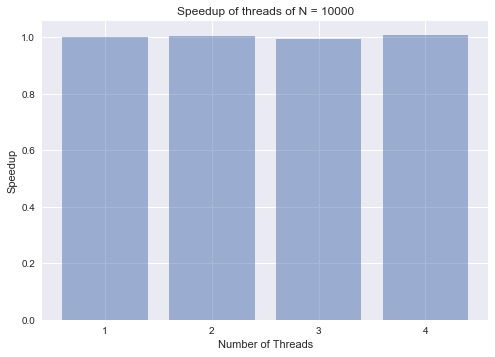

{'1': 1.0, '2': 1.0200588076890231, '3': 1.0023662857458695, '4': 0.9584143992871583}


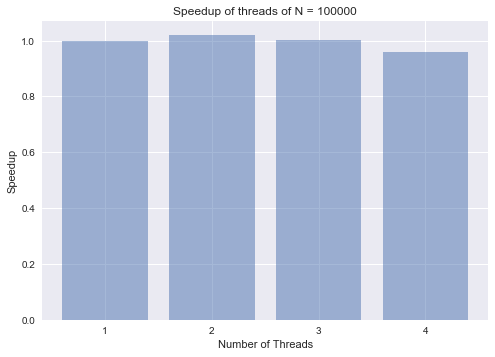

{'1': 1.0, '2': 1.0183222562276568, '3': 1.027797739662101, '4': 1.0481710987919173}


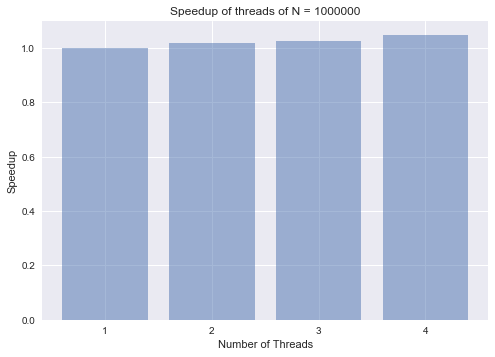

In [128]:
n_list = ['100','1000','10000','100000','1000000']
for n in n_list:
    sp_d = {}
    ts = time_d[n]['1'].median()
    for tp_index in time_d[n]:
        sp_d[tp_index] = ts/time_d[n][tp_index].median()
        
    print(sp_d)
        
    plt.bar(range(len(sp_d)), list(sp_d.values()), align='center', alpha = 0.5)
    plt.xticks(range(len(sp_d)), list(sp_d.keys()))
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup')
    plt.title('Speedup of threads of N = '+n)
    plt.show()

In [129]:
n_list = ['100','1000','10000','100000','1000000']
for n in n_list:
    print(n)
    for tp_index in time_d[n]:
        print(str(tp_index)+': '+str(time_d[n][tp_index].mean()))

100
1: 0.04633111953735351
2: 0.046333932876586915
3: 0.04864157438278198
4: 0.048600959777832034
1000
1: 0.09029593467712402
2: 0.09332282543182373
3: 0.09385350942611695
4: 0.09256372451782227
10000
1: 0.22061402797698976
2: 0.22077101469039917
3: 0.22108498811721802
4: 0.21720846891403198
100000
1: 1.5046032547950745
2: 1.5714595317840576
3: 1.549397349357605
4: 1.618557870388031
1000000
1: 11.876937162876128
2: 11.735591435432434
3: 11.738785529136658
4: 11.488408279418945
